# LRP-PF-AUC for VGG16

Try Region Perturbation using zennit on VGG16.

In [1]:
%load_ext autoreload
%autoreload 2

## LRP

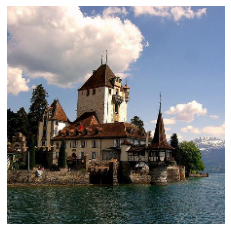

In [2]:
from typing import Callable, Dict, List, Tuple, Union

import numpy
import torch
import torchvision
from matplotlib import pyplot as plt
from zennit.composites import NameMapComposite
from zennit.core import BasicHook, stabilize
from zennit.image import imgify
# from lrp.rules import LrpEpsilonRule, LrpGammaRule, LrpZBoxRule, LrpZeroRule
from zennit.rules import Epsilon, Gamma, ZBox
from zennit.torchvision import ResNetCanonizer

import lrp.plot
from lrp import image, rules
from lrp.filter import LayerFilter
from lrp.zennit.types import AvgPool, Linear


# the LRP-Epsilon from the tutorial
class GMontavonEpsilon(BasicHook):
    def __init__(self, stabilize_epsilon=1e-6, epsilon=0.25):
        super().__init__(
            input_modifiers=[lambda input: input],
            param_modifiers=[lambda param, _: param],
            output_modifiers=[lambda output: output],
            gradient_mapper=(lambda out_grad, outputs: out_grad / stabilize(
                outputs[0] + epsilon * (outputs[0] ** 2).mean() ** .5, stabilize_epsilon)),
            reducer=(lambda inputs, gradients: inputs[0] * gradients[0])
        )

# Input data
# Image is in RGB mode with range [0,1]
img_bgr_hwc_float_0_1: numpy.array = image.load_img_norm_zero_one(
    '../../../data/castle2.jpg')
X = lrp.norm.ImageNetNorm.transform(img_bgr_hwc_float_0_1)
# Simulate batch by adding a new dimension
X = torch.unsqueeze(X, 0)
X.requires_grad = True

plt.axis('off')
lrp.plot.plot_imagenet(X)

# Model
model = torchvision.models.resnet50(pretrained=True)
model.eval()

# Low and high parameters for zB-rule
batch_size: int = 1
shape: Tuple[int] = (batch_size, 3, 224, 224)

low: torch.Tensor = lrp.norm.ImageNetNorm.normalize(torch.zeros(*shape))
high: torch.Tensor = lrp.norm.ImageNetNorm.normalize(torch.ones(*shape))

# Init layer filter
vgg16_target_types: Tuple[type] = (Linear, AvgPool)
filter_by_layer_index_type: LayerFilter = LayerFilter(model)
filter_by_layer_index_type.set_target_types(vgg16_target_types)

name_map: List[Tuple[List[str], rules.LrpRule,
                     Dict[str, Union[torch.Tensor, float]]]]
name_map = [
    (filter_by_layer_index_type(lambda n: n == 0), ZBox(low=low, high=high)),
    (filter_by_layer_index_type(lambda n: 1 <= n <= 16), Gamma(0.25)),
    (filter_by_layer_index_type(lambda n: 17 <= n <= 30), GMontavonEpsilon(stabilize_epsilon=0, epsilon=0.25)),
    (filter_by_layer_index_type(lambda n: 31 <= n), Epsilon(0)),
]

# create the composite from the name map
composite = NameMapComposite(name_map, canonizers=[ResNetCanonizer()])

R = None
# with composite.context(model) as modified_model:
#   # R: torch.Tensor = lrp_instance.relevance(X)
#   output = modified_model(X)
#   output[0].max().backward()

#   R = X.grad


composite.register(model)
# R: torch.Tensor = lrp_instance.relevance(X)
output = model(X)
output[0].max().backward()

R = X.grad

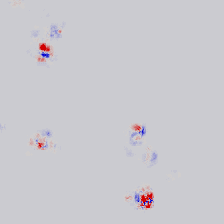

In [3]:
imgify(
    R.detach().cpu().sum(1),
    level=4.5,
    symmetric=True,
    grid=True,
    cmap='seismic')

## Region Perturbation

Try Region Perturbation with inpainting enabled.

Finished '_flip' in 0.0646 secs
Finished '_flip' in 0.0774 secs
Finished '_flip' in 0.0570 secs
Finished '_flip' in 0.0538 secs
Finished '_flip' in 0.0646 secs
Finished '_flip' in 0.0626 secs
Finished '_flip' in 0.0617 secs
Finished '_flip' in 0.0600 secs
Finished '_flip' in 0.0594 secs
Finished '_flip' in 0.0579 secs
Finished '_flip' in 0.0559 secs
Finished '_flip' in 0.0531 secs
Finished '_flip' in 0.0550 secs
Finished '_flip' in 0.0568 secs
Finished '_flip' in 0.0560 secs
Finished '_flip' in 0.0556 secs
Finished '_flip' in 0.0620 secs
Finished '_flip' in 0.0624 secs
Finished '_flip' in 0.0634 secs
Finished '_flip' in 0.0644 secs
Finished '_flip' in 0.0664 secs
Finished '_flip' in 0.0652 secs
Finished '_flip' in 0.0668 secs
Finished '_flip' in 0.0652 secs
Finished '_flip' in 0.0673 secs
Finished '_flip' in 0.0642 secs
Finished '_flip' in 0.0637 secs
Finished '_flip' in 0.0515 secs
Finished '_flip' in 0.0472 secs
Finished '__call__' in 1.8138 secs


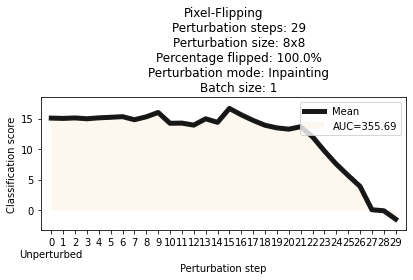

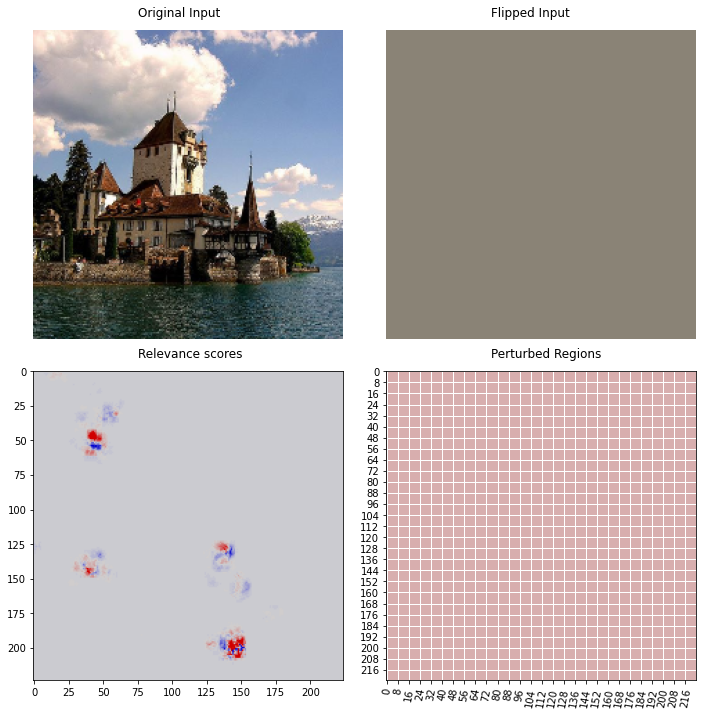

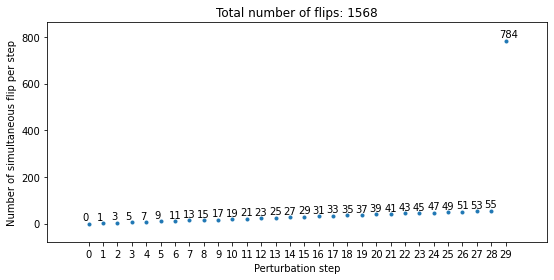

In [4]:
# %%script false --no-raise-error

from pf.core import PixelFlipping
# Parameters for cell: input_nchw, relevance_scores_nchw, lrp_instance
from pf.perturbation_modes.constants import PerturbModes

perturbation_steps: int = 29
perturbation_size: int = 8

pixel_flipping_instance: PixelFlipping = PixelFlipping(perturbation_steps=perturbation_steps,
                                                       perturbation_size=perturbation_size,
                                                       perturb_mode=PerturbModes.INPAINTING)
input_nchw: torch.Tensor = X.clone().detach()

# Enable reproducibility
torch.manual_seed(42)

relevance_scores_nchw: torch.Tensor = R.clone().detach()

# Function should return the (single-class) classification score for
# the given input to measure the difference between flips.
forward_pass: Callable[[torch.Tensor], float]
def forward_pass(input_nchw): return model(input_nchw)[:, 483]


# Run Pixel-Flipping algorithm
pixel_flipping_instance(input_nchw, relevance_scores_nchw, forward_pass)
pixel_flipping_instance.plot_class_prediction_scores()
pixel_flipping_instance.plot_image_comparison()
pixel_flipping_instance.plot_number_of_flips_per_step()

Finished '_flip' in 0.0517 secs
Finished '_flip' in 0.0464 secs
Finished '_flip' in 0.0450 secs
Finished '_flip' in 0.0453 secs
Finished '_flip' in 0.0465 secs
Finished '_flip' in 0.0466 secs
Finished '_flip' in 0.0471 secs
Finished '_flip' in 0.0457 secs
Finished '_flip' in 0.0461 secs
Finished '_flip' in 0.0456 secs
Finished '_flip' in 0.0493 secs
Finished '_flip' in 0.0474 secs
Finished '_flip' in 0.0459 secs
Finished '_flip' in 0.0468 secs
Finished '_flip' in 0.0463 secs
Finished '_flip' in 0.0477 secs
Finished '_flip' in 0.0487 secs
Finished '_flip' in 0.0486 secs
Finished '_flip' in 0.0529 secs
Finished '_flip' in 0.0483 secs
Finished '_flip' in 0.0493 secs
Finished '_flip' in 0.0500 secs
Finished '_flip' in 0.0476 secs
Finished '_flip' in 0.0471 secs
Finished '_flip' in 0.0488 secs
Finished '_flip' in 0.0493 secs
Finished '_flip' in 0.0493 secs
Finished '_flip' in 0.0484 secs
Finished '_flip' in 0.0437 secs
Finished '__call__' in 1.4353 secs


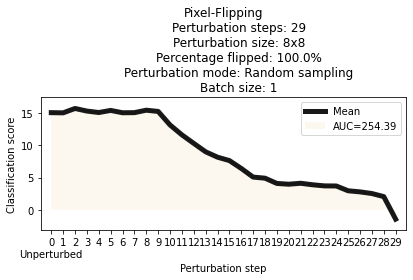

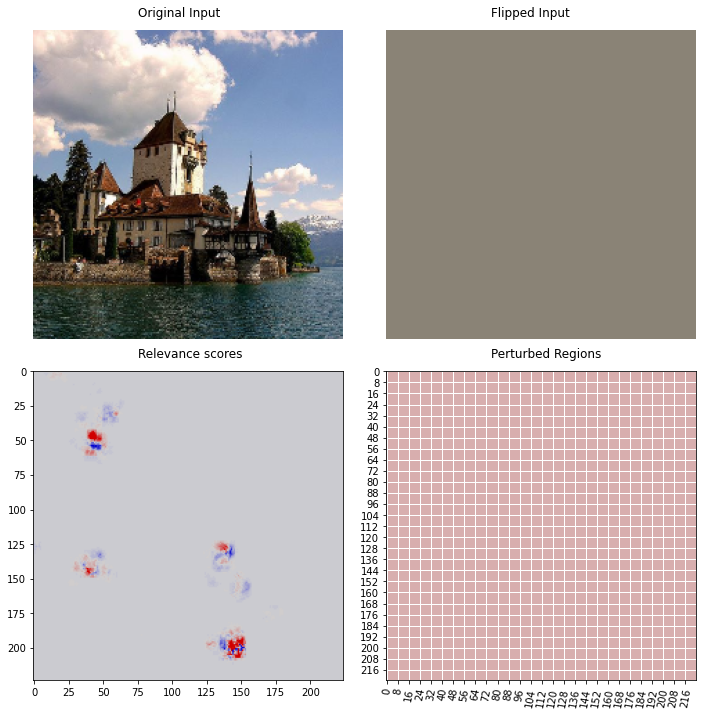

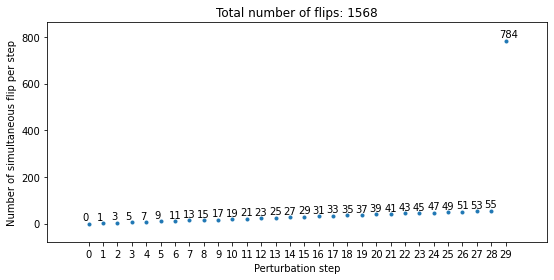

In [5]:
# %%script false --no-raise-error

from pf.core import PixelFlipping
# Parameters for cell: input_nchw, relevance_scores_nchw, lrp_instance
from pf.perturbation_modes.constants import PerturbModes

perturbation_steps: int = 29
perturbation_size: int = 8

pixel_flipping_instance: PixelFlipping = PixelFlipping(perturbation_steps=perturbation_steps,
                                                       perturbation_size=perturbation_size,
                                                       perturb_mode=PerturbModes.RANDOM)
input_nchw: torch.Tensor = X.clone().detach()

# Enable reproducibility
torch.manual_seed(42)

relevance_scores_nchw: torch.Tensor = R.clone().detach()

# Function should return the (single-class) classification score for
# the given input to measure the difference between flips.
forward_pass: Callable[[torch.Tensor], float]
def forward_pass(input_nchw): return model(input_nchw)[:, 483]


# Run Pixel-Flipping algorithm
pixel_flipping_instance(input_nchw, relevance_scores_nchw, forward_pass)
pixel_flipping_instance.plot_class_prediction_scores()
pixel_flipping_instance.plot_image_comparison()
pixel_flipping_instance.plot_number_of_flips_per_step()